In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aci import aci
from utils import pickle_load

/home/asuka/anaconda3/envs/py3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# prepare data and scores (use saved data from online_quantile.ipynb)
target_region = 'CA'
ahead = 1 # actual weeks ahead. to index, use ahead - 1
ahead_idx = ahead - 1
alpha = 0.3
raw_quantile_data = None
scores = []
y_preds = []
y_trues = []

pred_availiable = True
if pred_availiable:
    raw_quantile_data = pickle_load('data/saved_pred.pickle')
for i in range(len(raw_quantile_data)):
    predictions, addition_infos = raw_quantile_data[i]
    emb, y, meta = addition_infos[target_region]
    y_pred = predictions[target_region]
    y_trues.append(y[ahead_idx])
    y_preds.append(y_pred[ahead_idx])
    scores.append(np.abs(y_pred[ahead_idx] - y[ahead_idx]))
scores = np.array(scores)

In [3]:
results = aci(
    scores=scores,
    alpha=alpha,
    lr=0.05,
    T_burnin=5,
    window_length=20,
    ahead=ahead,
)

100%|██████████| 70/70 [00:00<00:00, 7551.67it/s]


<Figure size 640x480 with 0 Axes>

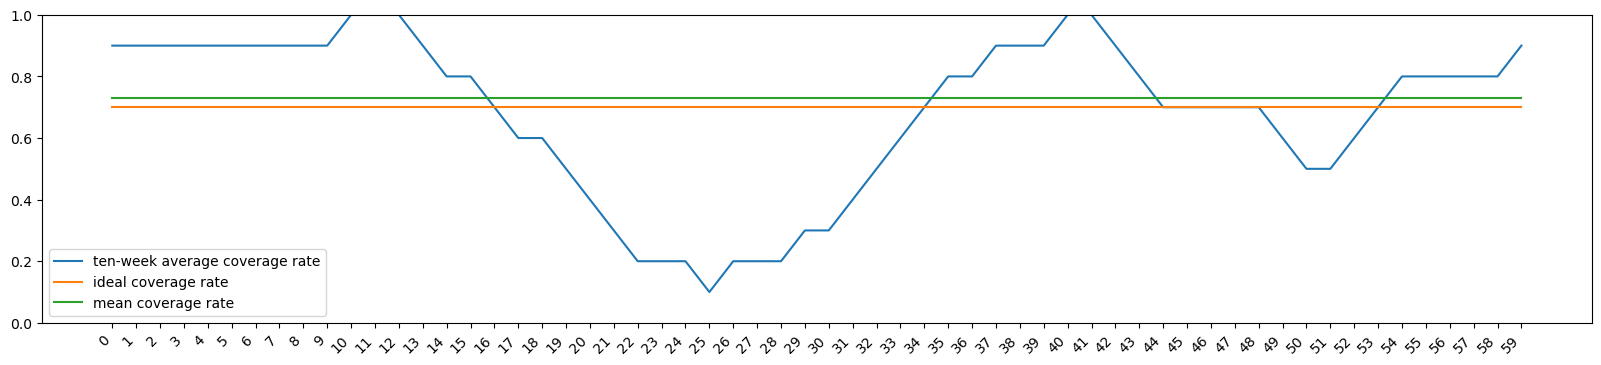

In [4]:
cov_history = [1 if results['q'][i] > scores[i] else 0 for i in range(results['q'].shape[0])]
avg_cov_rates = []
x_ticks = [i for i in range(results['q'].shape[0])]
for i in range(len(x_ticks) - 10):
    running_mean = 0
    for j in range(10):
        running_mean += cov_history[i+j]
    running_mean = running_mean / 10
    avg_cov_rates.append(running_mean)

mean_cov_rate = np.mean(cov_history)
plt.clf()
plt.figure(figsize=(20, 4))
x_ticks = x_ticks[:-10]
plt.ylim([0, 1])
plt.plot(x_ticks, avg_cov_rates, label='ten-week average coverage rate', )
plt.plot(x_ticks, [1 - alpha] * len(avg_cov_rates), label='ideal coverage rate')
plt.plot(x_ticks, [mean_cov_rate] * len(avg_cov_rates), label='mean coverage rate')
plt.xticks(x_ticks, rotation=45, ha='right')
plt.legend()
plt.show()

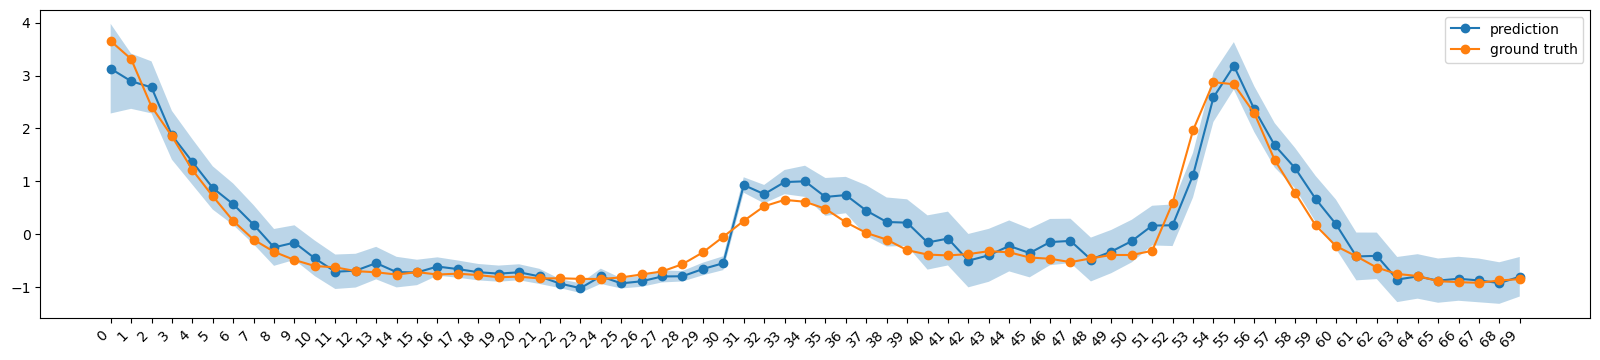

[0.84676114 0.52172128 0.49125655 0.46079182 0.4303271  0.40867314
 0.39142457 0.36900143 0.34806565 0.32685569 0.33581296 0.32538985
 0.31895704 0.30706184 0.28911942 0.24023782 0.17347675 0.16272996
 0.15531432 0.15225137 0.15135212 0.14309542 0.08557532 0.09119755
 0.14468259 0.09649413 0.1047523  0.11273707 0.09900884 0.11939015
 0.13080619 0.14609878 0.17428081 0.22853363 0.29469849 0.3579556
 0.34376888 0.47840764 0.46287629 0.44074991 0.51240738 0.50832281
 0.50423824 0.50015367 0.48150904 0.45938265 0.43725627 0.41869884
 0.4141836  0.40837161 0.40255963 0.37488011 0.39279275 0.42147013
 0.46326621 0.44789204 0.43251787 0.41973094 0.3814831  0.4346173
 0.4643226  0.45159176 0.43886091 0.42613007 0.42002012 0.41777235
 0.41552458 0.41312527 0.39247336 0.37369942]


In [5]:
def plot_helper(y_trues, y_preds, q_preds):
    x_ticks = [i for i in range(len(y_trues))]
    uppers, lowers = [], []
    for i in range(len(y_trues)):
        uppers.append(y_preds[i] + q_preds[i])
        lowers.append(y_preds[i] - q_preds[i])
    plt.figure(figsize=(20, 4))
    plt.plot(x_ticks, y_preds, '-o', label='prediction')
    plt.plot(x_ticks, y_trues, '-o', label='ground truth')
    plt.fill_between(x_ticks, lowers, uppers, alpha=0.3)
    plt.xticks(x_ticks, rotation=45, ha='right')
    plt.legend()
    plt.show()


plot_helper(y_trues, y_preds, results['q'])
print(results['q'])